# pyCBT tutorial

*29.10.2013 Leif Roschier/Aivon Oy (Finland)*

*26.05.2014 Angelo Di Marco/LPMMC - Grenoble (France)*


>**Note: this document is written with [ipython notebook](http://ipython.org/notebook.html) . You can install ipython, download this document and run it with your own computer.**

The python library [pyCBT](https://github.com/AivonOy/pyCBT/src) allows one to calculate the temperature of a Coulomb Blockade Thermometer (CBT) as well as other parameters of the temperature sensor. The values of all these quantities are extracted from the numerical fit of the CBT measured conductance curve $G^\textrm{meas}(V^\textrm{meas})$. All the calculations are based on the theory explained in the papers

[1] J. P. Pekola, *et. al.* , *Physical Review Letters*, volume **73**, page 2903 (1994)

[2] Sh. Farhangfar, *et. al.* , *Journal of Low Temperature Physics*, volume **108**, page 191 (1997).

[3] M. Meschke, J. P. Pekola, F. Gay, R. E. Rapp, and H. Godfrin, *J. Low Temp. Phys B* **134**, 1119 (2004). 

The main python file for the measured conductance fit is **fit_and_plot.py**. In the following, we go through it step-by-step.

First of all, the folder containing the needed libraries is added to the path.

In [1]:
import sys, time
from matplotlib import pyplot as plt
sys.path.append( '../src' ) # path indicating the folder where the libraries is
# this makes figures to pop up in this notebook
%matplotlib widget

Next we import the needed libraries

In [2]:
from CBT_lib import * # main lib # it contains the functions used to calculate numerically the current (Eq. (4) of the  
                                 # paper [1]) and its first derivative, i.e., the conductance, through one symmetric double 
                                 # junction array (one island case)
from CBT_fit_lib import * # lib for fitting the measured data
from CBT_plot_data_pyx import * # lib for plotting with pyx
from CBT_fit_multi_T import * # lib for fitting multiple curves simultaneously

and we set the main parameters that we use in the calculations

In [3]:
N_junctions=12        # number of junctions in each array
parallel_arrays = 3  # number of arrays in parallel 
island_size_init=(2.6E-6*0.1E-6*250E-10)*1E15 # 1e-15 m^3 # island size used to evaluate its heating due to the electron-phonon coupling
excitation = 250e-6/N_junctions  # AC voltage excitation of measurement

as well as the initial values of the variables used in the optimization (REMARK: the fit is very sensitive to the choice of these initial guesses)

In [4]:
T_init = 4 # K  # initial guess for the temperature
R_tunnel_init=13.0 # kOhm # initial guess for the tunnel resistance of the single junction
TEC_init=2 # K # double charging energy of the single island
# If bounds given, they are used to limit optimization
#R,C,T
bounds = [(1,20),(1,400),(3E3,7E3)] #(min,max)

Then we load the file containing the real measured data, $G^\textrm{meas}(V^\textrm{meas})$, (data file has one voltage column $(V^\textrm{meas})$ and one resistance column $(1/G^\textrm{meas})$) and we introduce the **fitter** object, used to have access to the fitting functions which are defined in the class CBT_fitter().

In [5]:
filename = "../src/data/max_test.txt"   # load of the real measured data 
fitter=CBT_fitter(filename=filename,T_init=T_init,island_size_init=island_size_init,
                      R_tunnel_init=R_tunnel_init,TEC_init=TEC_init,
                        bounds=bounds,const_P=500e-18,
                        excitation=excitation,parallel_arrays=parallel_arrays,
                        junctions_in_series = N_junctions)  # fitting class defined in CBT_fit_lib.py

Besides the parameters already mentioned, in **fitter** two more variables are introduced. 

1) The number of junctions **N** of the array to which the whole system is reduced to simplify the calculations. Note that, in general, the minimum value of $N$ is 2. Indeed, the case $N=1$ corresponds to just a single junction CBT, whose current does not depend on temperature anymore (at least according to the formalism used in the papers [1] and [2]) because of the absence of an island where charge can be localized. In order to use Eq.(4) of the paper [1], in all the calculations the case $N=2$ is considered. 

2) The constant heat power noise **const_P** which typically affects measurements even when the bias voltage is zero.


Before the fitting procedure starts, the offset of the experimental data introduced by the voltmeter has to be calculated and the conductance curve corrected accordingly. The offset is obtained as the position in the voltage axis of the minimum of the parabola which fits the region around the zero-bias measured conductance.

 Calculated Voltage Offset = -3.89101e-05


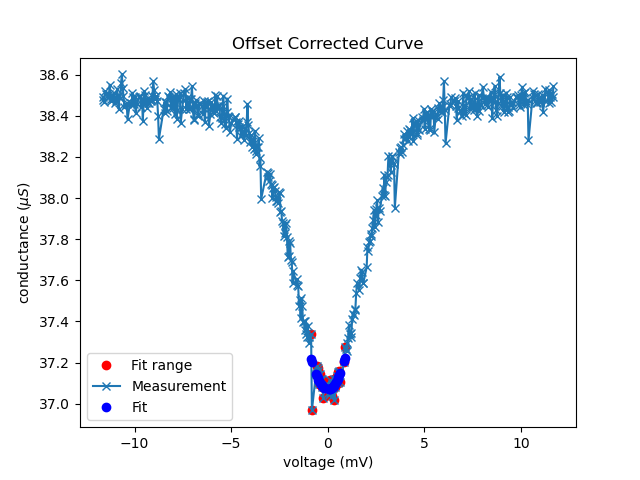

In [11]:
plt.close("all")
fitter.find_offset(15, offset=14) # find the offset using 5 points around the minimum of the measured conductance curve and shift the 
                      # measured data by the obtained offset value
fitter.print_offset_curve()  # plot of the shifted conductance curve and on top of it the shifted data points used to 
                             # determine the position of the minimum (red dots) as well as the corresponding points belonging 
                             # to the fitting parabola (blue dots)

The fitting procedure consists of two stages.

First of all, the experimental data $G^\textrm{meas}(V^\textrm{meas})$ are fitted using the classical first-order analytical conductance, $G_\textrm{first}(V)$, valid in the high temperature limit. In this way, one is able to find rapidly the set of good starting parameters that will be used later when the data will be fitted with the numerical derivative of the current (4) of paper [1].

The high-temperature conductance of an array of $N$ junctions is (see Eq.(3) of paper [2]):

\begin{equation}
G_\textrm{first}(v_N) = \frac{G_T}{N}\left[1 - 2\left(\frac{N-1}{N}\right)\left(\frac{e^2/C_\Sigma}{k_B T}\right) \left(\frac{v_N \sinh(v_N)-4\sinh^2(v_N/2)}{8\sinh^4(v_N/2)}\right)\right] \ .
\end{equation}

Here $T$ is the temperature of both electrons and phonons of the CBT; $v_N = eV/Nk_BT$ is the bias voltage $V$ scaled with $T$; $e^2/C_\Sigma$ is twice the charging energy $E_C=e^2/2C_\Sigma$ of the single island with total capacitance $C_\Sigma=2C+C_0$, for the symmetric case; $C$ and $C_0$ are the capacitance of the single junction and the ground capacitance of the island respectively; $G_T=1/R_T$ is the tunnel conductance of each single junction of the array, obtained when $V\rightarrow\pm\infty$. Throughout the fitting procedure we set N=2.

In order to find the optimal parameters $G_T$, $T$ and $e^2/C_\Sigma/k_B$ such that $G_\textrm{first}(v_N)$ approximates the experimental conductance, we minimize the quadratic error

\begin{equation}
\varepsilon_1=\sum_{i=1}^{n_\textrm{points}}\left[ G_i^{meas}-G_\textrm{first}(V_i^{meas})\right]^2
\end{equation}

In this equation, $n_\textrm{points}$ is the number of the measured data points, $G_i^{meas}$ the $i$-th measured conductance and $G_\textrm{first}(V_i^{meas})$ the first-order conductance $G_\textrm{first}(v_N)$ evaluated at the $i$-th measured voltage drop $V_i^{meas}$. To minimize the error $\varepsilon$ we make use of the Broyden-Fletcher-Goldfarb-Shanno (BFGS) method.

Numbers below show how [ $G_T$ , $T$ , $e^2/C_\Sigma/k_B$ ] = [ single junction tunnel conductance ($1 / k\Omega$) , temperature ($\textrm{K}$) , double charging energy ($\textrm{K}$) ] evolve during the optimization.

==============  Starting Values   ===============
Rt_init: 13 KOhm T_init: 4000 mK E_C_init: 2000 mK
[0.07746159 4.00000034 1.9999987 ]
[0.07733253 4.08775144 1.74316047]
[0.0767511  2.77368814 0.67244599]
[0.07691102 3.51334898 0.94378135]
[0.07691539 3.81932151 0.94680503]
[0.07691809 4.24147142 0.95651546]
[0.07692719 4.45830542 0.97167056]
[0.07693209 4.54758668 0.97999158]
[0.07693305 4.56166689 0.98163947]
[0.07693315 4.56246408 0.98180033]
[0.07693316 4.56250835 0.98182506]
[0.07693316 4.56249469 0.98182612]
[0.07693316 4.56249775 0.98182635]
[0.07693316 4.56249859 0.98182656]
         Current function value: 0.104432
         Iterations: 14
         Function evaluations: 165
         Gradient evaluations: 40
====== After initial optimization: ======
R_T = 12.9983 kOhm
R_T_arrays = 51.9932 kOhm
T = 4562.5 mK
Ec = 490.913 mK
Csigma = 1.89366 fF


C:\Users\mp250\AppData\Local\mambaforge\Lib\site-packages\scipy\optimize\_optimize.py:1360: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


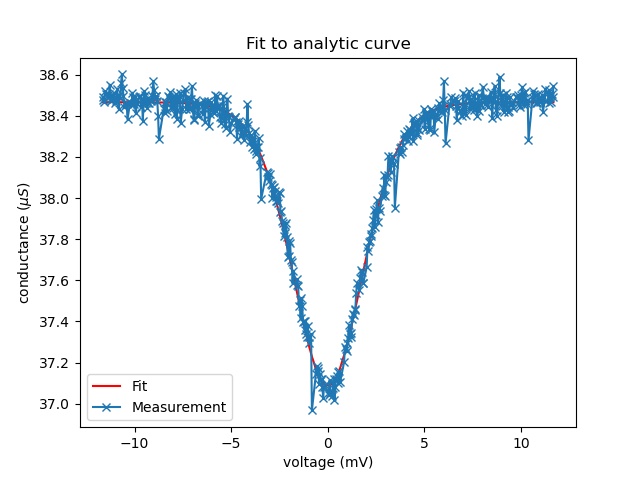

In [12]:
fitter.fit_classic_curve() # fit of the measured data with the high-temperature analytical conductance
fitter.plot_result_initial() # plot of the measured curve (blue) and of the optimized high-temperature analytical
                             # conductance (red)

Once we obtained the optimal parameters [ $G_T^\textrm{opt}$ , $T^\textrm{opt}$ , $(e^2/C_\Sigma/k_B)^\textrm{opt}$ ], we use them as starting values for the second fitting stage where the measured data $G^\textrm{meas}(V^\textrm{meas})$ are fitted with the first derivative of the current $I$ given by Eq.(4) of the paper [1], which is valid at all orders in $T$.

The derivative $dI/dV=G_\textrm{all}$ is calculated numerically using the five-point stencil formula:

\begin{equation}
G_\textrm{all}(V_i^\textrm{meas})=\left.\frac{dI}{dV}\right|_{V_i^\textrm{meas}}\simeq \frac{1}{12 h}\left[ -I(V_i^\textrm{meas}+2h)+8 \ I(V_i^\textrm{meas}+h)-8 \ I(V_i^\textrm{meas}-h)+I(V_i^\textrm{meas}-2h)  \right]+O(h^4) \ .
\end{equation}

The spacing $h$ between two adjacent points of the stencil is chosen equal to the parameter *excitation* defined and initialized at the beginning of the fitting procedure.

The optimal fitting parameters that now we want to calculate are the tunnel resistance of the single junction $R_T$, the total capacitance of the single island $C_\Sigma$, and the phonons temperature $T_\textrm{ph}$. The latter is assumed different from the electronic temperature $T_\textrm{el}$ because of the heat exchange between the island and the substrate. In order to have $I$ and its first derivative as a function of $T_\textrm{ph}$, we replace $T_\textrm{el}$ in $I$ with the electron-phonon coupling relation

\begin{equation}
T_\textrm{el}=\left( \frac{P_\textrm{per junc}}{\Sigma\Omega}+T_\textrm{ph}^5 \right)^{1/5} \ .
\end{equation}

Here $\Sigma$ and $\Omega$ are the electron-phonon coupling constant and the volume of the island respectively, and $P_\textrm{per junc}$ is the sum of the heat power of the single junction $(V/N)^2/R_T$ and the constant heat noise *const_P*.

As in the previous stage, the fit of $G^\textrm{meas}(V^\textrm{meas})$ with $G_\textrm{all}(V^\textrm{meas})$ is performed minimizing the quadratic error

\begin{equation}
\varepsilon_2=\sum_{i=1}^{n_\textrm{points}}\left[ G_i^{meas}-G_\textrm{all}(V_i^{meas})\right]^2
\end{equation}

by means of the Broyden-Fletcher-Goldfarb-Shanno (BFGS) method. During the optimization the tunnel resistance per junction $R_T$ (Rt), the total capacitance $C_\Sigma$ (Csigma), the phonon temperature $T_\textrm{ph}$ (Tp) and the error function (res) are shown (see below). Fitting takes some time in this second stage that is measured and printed. At the end, the calculated optimal parameters are printed together with a plot showing the measured data and the fitting curve.

Using pr fitted values
Optimizing with bounds
Rt: 12998.3 Csigma: 1.89366e-15 Tp: 4.5625 res: 0.0105972
Rt: 12998.3 Csigma: 1.89366e-15 Tp: 4.5625 res: 0.0105972
Rt: 12998.3 Csigma: 1.89366e-15 Tp: 4.5625 res: 0.0105972
Rt: 12998.3 Csigma: 1.89366e-15 Tp: 4.5625 res: 0.0105972
Rt: 12987.8 Csigma: 1.87186e-15 Tp: 4.5625 res: 0.0138423
Rt: 12987.8 Csigma: 1.87186e-15 Tp: 4.5625 res: 0.0138423
Rt: 12987.8 Csigma: 1.87186e-15 Tp: 4.5625 res: 0.0138423
Rt: 12987.8 Csigma: 1.87186e-15 Tp: 4.5625 res: 0.0138423
Rt: 12997.5 Csigma: 1.89199e-15 Tp: 4.5625 res: 0.0105748
Rt: 12997.5 Csigma: 1.89199e-15 Tp: 4.5625 res: 0.0105748
Rt: 12997.5 Csigma: 1.89199e-15 Tp: 4.5625 res: 0.0105748
Rt: 12997.5 Csigma: 1.89199e-15 Tp: 4.5625 res: 0.0105748
Rt: 12997.4 Csigma: 1.8903e-15 Tp: 4.5625 res: 0.0105378
Rt: 12997.4 Csigma: 1.8903e-15 Tp: 4.5625 res: 0.0105378
Rt: 12997.4 Csigma: 1.8903e-15 Tp: 4.5625 res: 0.0105378
Rt: 12997.4 Csigma: 1.8903e-15 Tp: 4.5625 res: 0.0105378
Rt: 12997.2 Csigma: 1.88352e-1

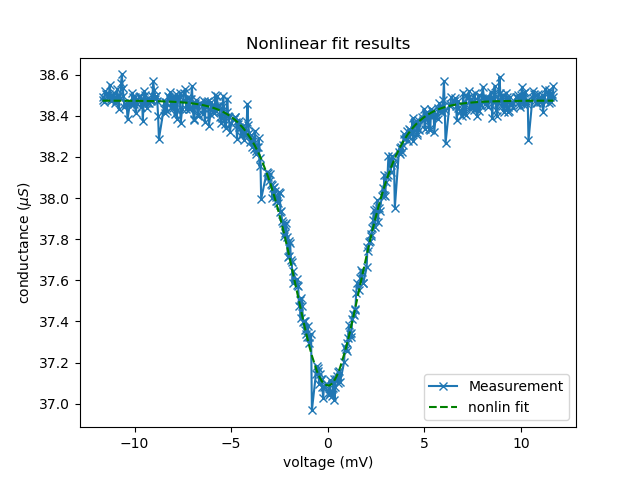

Optimization took 114.979 seconds = 1.91631 minutes



Rt: 25410.4 Csigma: 2.31589e-13 Tp: 0.0213336 res: 0.00377807


Rt: 25410.4 Csigma: 2.31589e-13 Tp: 0.0213336 res: 0.00377807


Rt: 25410.4 Csigma: 2.31589e-13 Tp: 0.0213336 res: 0.00377807


Rt: 25410.4 Csigma: 2.31589e-13 Tp: 0.0213336 res: 0.00377807


Rt: 25410.4 Csigma: 2.31589e-13 Tp: 0.0213336 res: 0.00377807


Rt: 25413.7 Csigma: 2.31577e-13 Tp: 0.0211757 res: 0.00368573


Rt: 25413.7 Csigma: 2.31577e-13 Tp: 0.0211757 res: 0.00368573


Rt: 25413.7 Csigma: 2.31577e-13 Tp: 0.0211757 res: 0.00368573


Rt: 25413.7 Csigma: 2.31577e-13 Tp: 0.0211757 res: 0.00368573


Rt: 25413.7 Csigma: 2.31577e-13 Tp: 0.0211757 res: 0.00368573


Rt: 25415.7 Csigma: 2.31552e-13 Tp: 0.0208561 res: 0.00352468


Rt: 25415.7 Csigma: 2.31552e-13 Tp: 0.0208561 res: 0.00352468


Rt: 25415.7 Csigma: 2.31552e-13 Tp: 0.0208561 res: 0.00352468


Rt: 25415.7 Csigma: 2.31552e-13 Tp: 0.0208561 res: 0.00352468


Rt: 25415.7 Csigma: 2.31552e-13 Tp: 0.0208561 res: 0.00352468


Rt: 25413.1 Csigma: 2.31526e-13 Tp: 0.0205334 res: 0.00338404


Rt: 25413.1 Csigma: 2.31526e-13 Tp: 0.0205334 res: 0.00338404


Rt: 25413.1 Csigma: 2.31526e-13 Tp: 0.0205334 res: 0.00338404


Rt: 25413.1 Csigma: 2.31526e-13 Tp: 0.0205334 res: 0.00338404


Rt: 25413.1 Csigma: 2.31526e-13 Tp: 0.0205334 res: 0.00338404


Rt: 25408.3 Csigma: 2.31517e-13 Tp: 0.020427 res: 0.00332773


Rt: 25408.3 Csigma: 2.31517e-13 Tp: 0.020427 res: 0.00332773


Rt: 25408.3 Csigma: 2.31517e-13 Tp: 0.020427 res: 0.00332773


Rt: 25408.3 Csigma: 2.31517e-13 Tp: 0.020427 res: 0.00332773


Rt: 25408.3 Csigma: 2.31517e-13 Tp: 0.020427 res: 0.00332773


Rt: 25406.1 Csigma: 2.3152e-13 Tp: 0.020456 res: 0.00332039


Rt: 25406.1 Csigma: 2.3152e-13 Tp: 0.020456 res: 0.00332039


Rt: 25406.1 Csigma: 2.3152e-13 Tp: 0.020456 res: 0.00332039


Rt: 25406.1 Csigma: 2.3152e-13 Tp: 0.020456 res: 0.00332039


Rt: 25406.1 Csigma: 2.3152e-13 Tp: 0.020456 res: 0.00332039


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204683 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204683 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204683 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204683 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204683 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204688 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204688 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204688 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204688 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204688 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204706 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204706 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204706 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204706 res: 0.00332026


Rt: 25405.9 Csigma: 2.31521e-13 Tp: 0.0204706 res: 0.00332026


======   After main optimization:   ======
R_T = 25.4059
T = 20.4706 mK
C_sigma = 231.521 


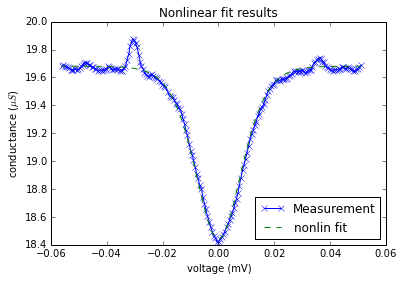

Optimization took 100.452 seconds = 1.6742 minutes


In [13]:
tic = time.clock() # start timing
fitter.fit_full_curve() # fit of the conductance data with the first derivative of the current given by Eq.(4) of paper [1]
fitter.plot_nonlin_results() # plot of the results
toc = time.clock() # take time
print("Optimization took %g seconds = %g minutes"%(toc-tic,(toc-tic)/60.0)) # print time